### In this notebook, we test various stepsize patterns presented in [1] "Provably Faster Gradient Descent via Long Steps" by Benjamin Grimmer ###

In [1]:
import numpy as np
import matplotlib.pyplot as plt

To reproduce the results in [1] p. 4, we use two objective functions of the least squares problem: <br>
$f(x) = ||Ax-b||_2^2$ where $A\in\mathbb{R}^{n\times n}$, $b \in \mathbb{R}^n$ with i.i.d normal entries and $n=4000$ <br>
$g(x) = ||Ax-b||_2^2 + ||x||_2^2$  with identical $A, b$ and an added regularizer term <br> <br>

for these functions, the gradients are the following: <br>
$\nabla_x f(x) = 2 A^T(Ax-b)$ <br>
$\nabla_x g(x) = 2 A^T(Ax-b) + 2 x$ <br> <br>

What is left is to calculate the Lipschitz constants for the gradients. In fact, for any $x,y \in \mathbb{R}^n$, we have <br>
$||\nabla_x f(x) - \nabla_x f(y)|| = || 2 A^T(Ax-b-Ay+b)|| = ||2A^TA(x-y)|| \le 2||A^TA||||x-y|| = L_1 ||x-y||$ with $L_1 = 2||A||^2$ <br>
and similarly, <br>
$||\nabla_x g(x) - \nabla_x g(y)|| \le L_2 ||x-y||$ with $L_2 = 2||A^TA + I||$ <br> <br>

Below, we create a random least squares problem and provide a function for gradient descent with stepsize patterns of variable length 

In [2]:
#generate random least squares problem
s = 4000
b = np.random.normal(size=(s,1))
A = np.random.normal(size=(s,s))
ID = np.identity(s)

#calculate A^T times A for the gradient and the Lipschitz constant
A_T = np.transpose(A)
A_T_A = np.matmul(A_T,A) 
L_1 = 2 * np.linalg.norm(A,2)**2
L_2 = 2 * np.linalg.norm(A_T_A + s * ID,2)
print("L = " + str(L_1) + " without regularizeation, " + str(L_2) + " with regularization")
#helper functions for gradient descent

#evaluate objective function without regularizer
def objective1(x):
    return np.linalg.norm(np.matmul(A,x)-b,2)**2

#...with regularizer
def objective2(x):
    return objective1(x) + s * np.linalg.norm(x,2)**2

#evaluate gradient of objective function without regularizer
def grad1(x):
    return 2 * (np.matmul(A_T_A,x) - np.matmul(A_T,b)) 

#...with regularizer
def grad2(x):
    return grad1(x) + 2 * s * x



#calculate a single gradient-descent step given the stepsize and the value of the previous step, without regularizer
def gradstep1(x,h):
    return x - (h/L_1)*grad1(x)

#...with regularizer
def gradstep2(x,h):
    return x - (h/L_2)*grad2(x)



L = 31714.94704259817 without regularizeation, 39714.9470425981 with regularization


Compute near to optimal solution with numpy function

In [3]:
X_opt, res_opt, rank_opt, s_opt = np.linalg.lstsq(A,b)
#print(objective1(X_opt),np.linalg.norm(X_opt),objective2(X_opt))

C:\Users\mayer\AppData\Local\Temp\ipykernel_11056\3736949139.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  X_opt, res_opt, rank_opt, s_opt = np.linalg.lstsq(A,b)


In [4]:
#function for gradient descent with stepsize pattern
def graddesc(x_0,H,T,reg = False):

    result = np.zeros(T)
    X = np.zeros((T,4000,1))
    if(reg): 
        obj = objective2
        gradstep = gradstep2
    else: 
        obj = objective1
        gradstep = gradstep1

    result[0] = obj(x_0)
    X[0,:] = x_0
    for t in range (1,T):
        h = H[(t-1) % len(H)]
        X[t,:] = gradstep(X[t-1,:],h)
        result[t] = obj(X[t])
        # if(t//100 == 1):
        #     print("t= ",t," h_t = ", h, " objective =", result[t])#, "gradient = ", gradstep(X[t-1,:],h))
    return X, result


Now, we test the stepsize patterns provided in [1] on our random least square problem

In [5]:
# initial value
x_0 = np.zeros_like(b)

# number of descent iterations
T = 2000

#set stepsize patterns
H_GRDESC = [1]
H_2 = [2.9, 1.5] # taking nu = 0.1
H_3 = [1.5, 4.9, 1.5]
H_7 = [1.5, 2.2, 1.5, 12.0, 1.5, 2.2, 1.5]
H_15 = [1.4, 2.0, 1.4, 4.5, 1.4, 2.0, 1.4, 29.7, 1.4, 2.0, 1.4, 4.5, 1.4, 2.0, 1.4]
H_31 = [1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 8.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 72.3, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 8.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4]
H_63 = [1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 7.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 14.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 7.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 164.0, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 7.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 14.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 7.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4]
H_127 = [1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 7.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 12.6, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 7.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 23.5, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 7.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 12.6, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 7.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 370.0, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 7.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 12.6, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 7.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 23.5, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 7.5, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 12.6, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4, 7.2, 1.4, 2.0, 1.4, 3.9, 1.4, 2.0, 1.4]

H = [H_GRDESC,H_2,H_3,H_7,H_15,H_31,H_63,H_127]
X = []
X_REG = []
RESULT = []
RESULT_REG = []

#execute gradient descent for each stepsize pattern
for H_i in H:
    x, res = graddesc(x_0,H_i,T,reg=False)
    X.append(x)
    RESULT.append(res)

    x, res = graddesc(x_0,H_i,T,reg=True)
    X_REG.append(x)
    RESULT_REG.append(res)


KeyboardInterrupt: 

Below, we visualize the value of the Objective function for each stepsize pattern over the gradient descent iterations 

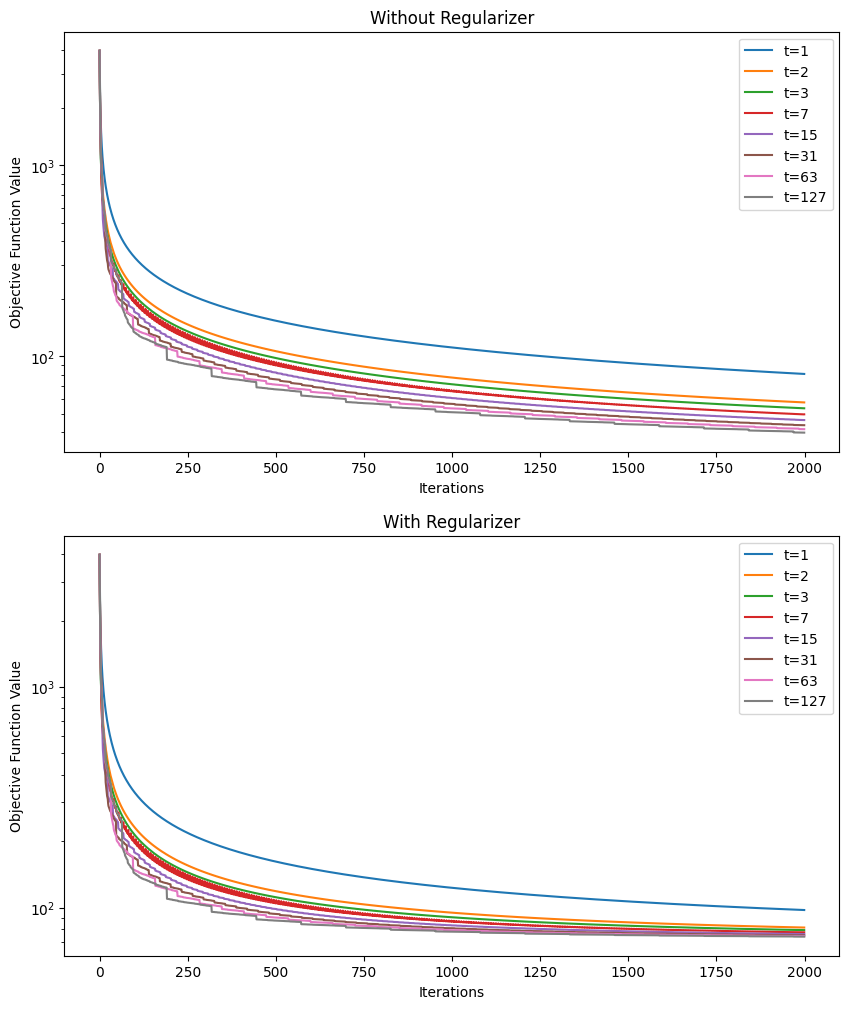

In [89]:
fig, (ax1,ax2) = plt.subplots(2,1)
fig.set_figwidth(10)
fig.set_figheight(12)
for i, H_i in enumerate(H):
    ax1.plot(RESULT[i],label='t=' + str(len(H_i)))  
    ax2.plot(RESULT_REG[i],label='t=' + str(len(H_i)))  

ax1.set_yscale('log')
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Objective Function Value")
ax1.set_title("Without Regularizer")
ax1.legend()

ax2.set_yscale('log')
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Objective Function Value")
ax2.set_title("With Regularizer")
ax2.legend()


To visualize the effect of regularization, we plot the norm of the solutions over iterations

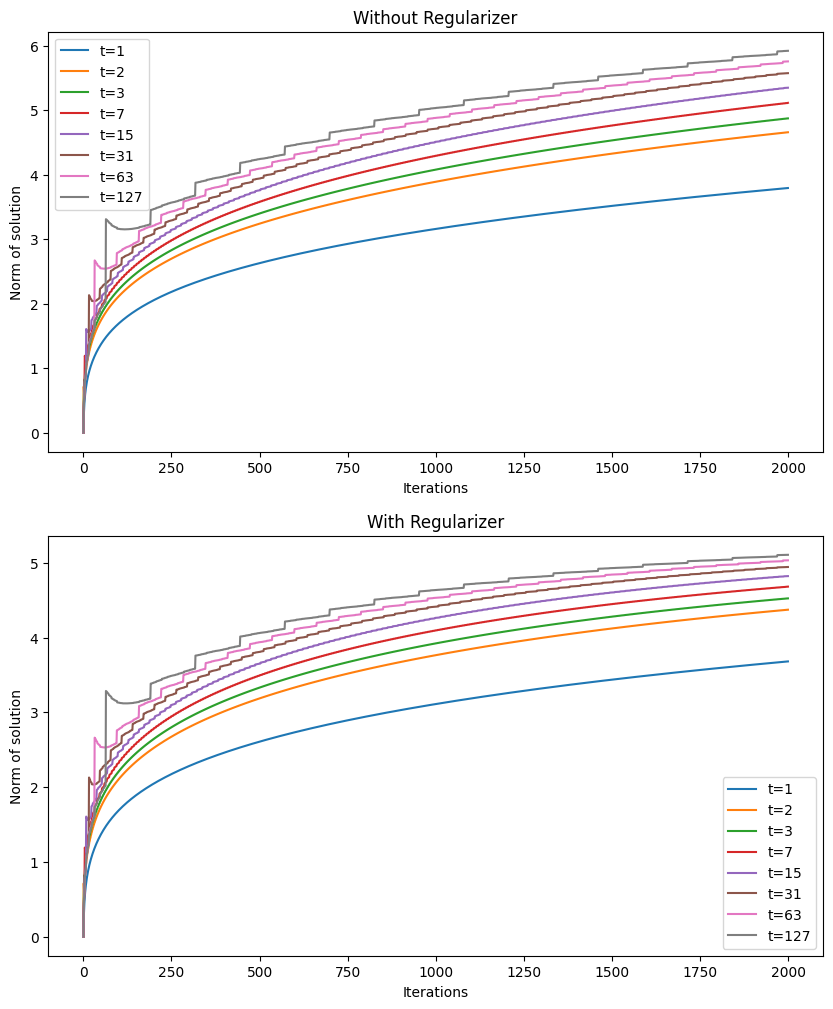

In [90]:
fig, (ax1,ax2) = plt.subplots(2,1)
fig.set_figwidth(10)
fig.set_figheight(12)
for i, H_i in enumerate(H):
    ax1.plot(np.linalg.norm(X[i],2,axis=1),label='t=' + str(len(H_i)))  
    ax2.plot(np.linalg.norm(X_REG[i],2,axis=1),label='t=' + str(len(H_i)))  

#ax1.set_yscale('log')
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Norm of solution")
ax1.set_title("Without Regularizer")
ax1.legend()

#ax2.set_yscale('log')
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Norm of solution")
ax2.set_title("With Regularizer")
ax2.legend()

Finally, we plot the distance of the solution from the "optimal solution" obtained from the least square minimizer

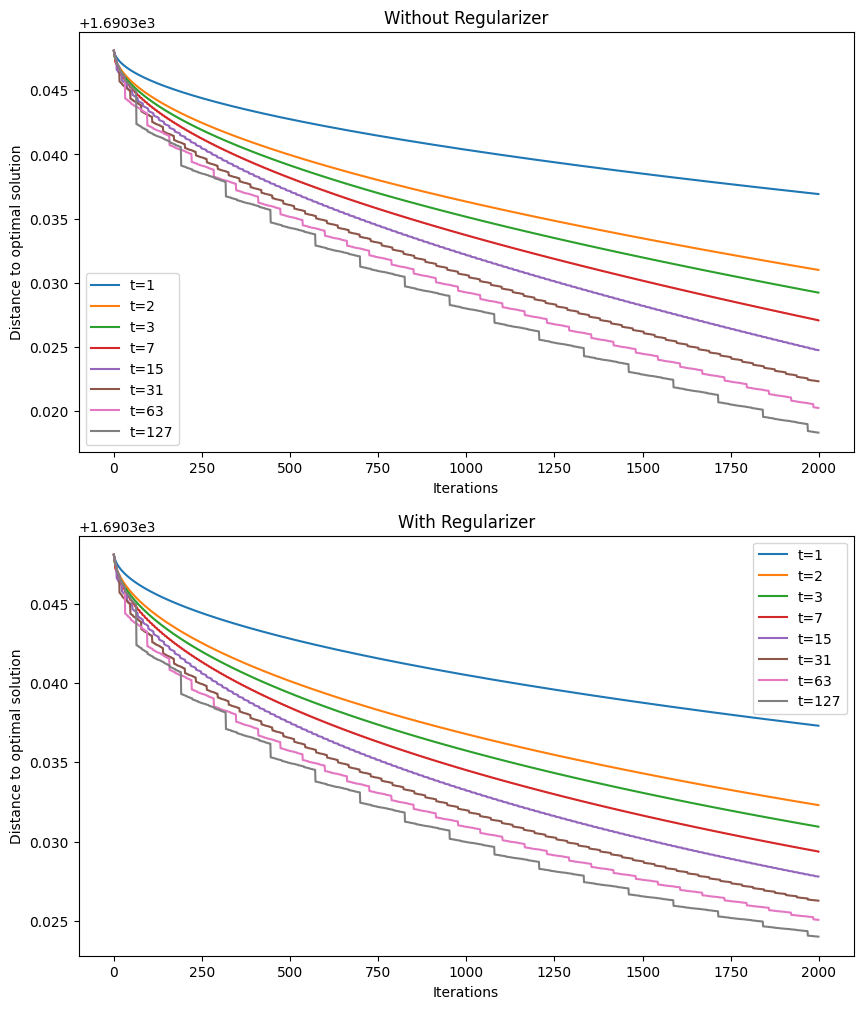

In [92]:
fig, (ax1,ax2) = plt.subplots(2,1)
fig.set_figwidth(10)
fig.set_figheight(12)
for i, H_i in enumerate(H):
    ax1.plot(np.linalg.norm(X_opt - X[i],2,axis=1),label='t=' + str(len(H_i)))  
    ax2.plot(np.linalg.norm(X_opt - X_REG[i],2,axis=1),label='t=' + str(len(H_i)))  

#ax1.set_yscale('log')
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Distance to optimal solution")
ax1.set_title("Without Regularizer")
ax1.legend()

#ax2.set_yscale('log')
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Distance to optimal solution")
ax2.set_title("With Regularizer")
ax2.legend()

In [96]:
#print(np.sum(X[1][500,:,:]),X[1][500,:,:])

for i,h in enumerate(H):
    print("length " + str(len(h)),RESULT[i][1999],RESULT_REG[i][1999]-np.linalg.norm(X[1][1999,:,:],2)**2)
    print("length " + str(len(h)),RESULT[i][1999],RESULT_REG[i][1999]-np.linalg.norm(X[1][1999,:,:],2)**2)

length 1 80.83837989083442 75.95943008009668
length 2 57.357910633329375 59.660772150208686
length 3 53.43512577751665 57.508306418329425
length 7 49.67563350617742 55.711472829775545
length 15 46.37133133674982 54.30503339252073
length 31 43.587398928799075 53.32814387757077
length 63 41.546023411059615 52.72443206611315
length 127 39.85353669485101 52.294221039281666
